In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

C:\Users\Felicity\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv(r"C:\Users\Felicity\Downloads\bank.csv" , sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
# Check for missing words
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [4]:
# Check the shape of the df
df.shape

(45211, 17)

In [5]:
# Cleaning of data by classifying the customers according to thier balance
def balanceator(x):
    if x < 72:
        return 'Class E'
    elif x >= 72 and x < 448:
        return 'Class D'
    elif x >= 448 and x < 1428:
        return 'Class C'
    elif x >= 1428 and x < df['balance'].quantile(0.99):
        return 'Class B'
    else:
        return 'Class A'

In [6]:
def wrangle(path):
    df = pd.read_csv(path, sep=';') # Read CSV file
    df['y'] = df['y'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
    df['default'] = df['default'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
    df['balance_class'] = df['balance'].apply(lambda x: balanceator(x)) # Creates a new categoric column 'balance_class' using data from 'balance' column
    df['housing'] = df['housing'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
    df['loan'] = df['loan'].apply(lambda x: True if x == 'yes' else False) # Change object output to bool
    df['previous_bool'] = df['previous'].apply(lambda x: True if x != 0 else False) # Change object output to bool for visualization and modeling purpuses
    
    
    #drop columns:
    to_drop =['previous', 'day', 'poutcome', 'pdays'] 
    df.drop(columns= to_drop, inplace=True)
    
    
    return df

In [7]:
df_pos = wrangle('C:/Users/Felicity/Downloads/bank.csv')

In [8]:
df_pos.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,y,balance_class,previous_bool
0,58,management,married,tertiary,False,2143,True,False,unknown,may,261,1,False,Class B,False
1,44,technician,single,secondary,False,29,True,False,unknown,may,151,1,False,Class E,False
2,33,entrepreneur,married,secondary,False,2,True,True,unknown,may,76,1,False,Class E,False
3,47,blue-collar,married,unknown,False,1506,True,False,unknown,may,92,1,False,Class B,False
4,33,unknown,single,unknown,False,1,False,False,unknown,may,198,1,False,Class E,False


In [9]:
# seperate the variables
X = df_pos.drop(columns = ["y", "balance", 'duration'])
y = df_pos['y']

In [10]:
oe = OrdinalEncoder()
X = oe.fit_transform(X)

In [11]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [12]:
# Apply machine learning model
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), {}, n_jobs=-1, cv=10, refit="recall")
dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1, param_grid={}, refit='recall')

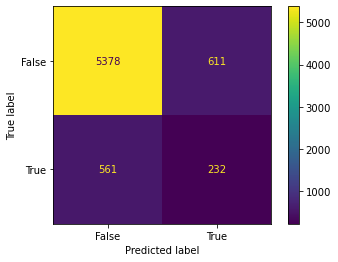

In [13]:
ConfusionMatrixDisplay.from_estimator(dt,X_test,y_test)


In [14]:
pred = dt.predict(X_test)

In [15]:
print (classification_report(pred, y_test))

              precision    recall  f1-score   support

       False       0.90      0.91      0.90      5939
        True       0.29      0.28      0.28       843

    accuracy                           0.83      6782
   macro avg       0.60      0.59      0.59      6782
weighted avg       0.82      0.83      0.82      6782



In [16]:
# increase the accuracy
params_dt = {
    "max_depth": [5, 10, 15, 20, 25, 30, None], # Maximum depth of the decision tree
    "criterion": ["gini","entropy"], # The quality criterion to measure the information gain when splitting nodes
    "min_samples_split": [2,3], # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1,2] # Minimum number of samples required to be at a leaf node
}

In [17]:
model_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42), # Define the Decision Tree model
    params_dt, # Pass in the hyperparameters to be tuned from the dictionary we defined earlier
    cv=10, # Set the number of folds for cross-validation
    verbose=2
)

In [18]:
model_dt.fit(X_train, y_train)

Fitting 10 folds for each of 56 candidates, totalling 560 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25, 30, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             verbose=2)

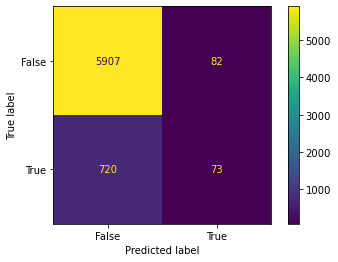

In [19]:
ConfusionMatrixDisplay.from_estimator(model_dt,X_test,y_test)

In [20]:
pred_dt = model_dt.predict(X_test)

In [21]:
print (classification_report(pred_dt, y_test))

              precision    recall  f1-score   support

       False       0.99      0.89      0.94      6627
        True       0.09      0.47      0.15       155

    accuracy                           0.88      6782
   macro avg       0.54      0.68      0.55      6782
weighted avg       0.97      0.88      0.92      6782

